In [1]:
from argparse import ArgumentParser, Namespace
from pathlib import Path
import pickle
import sys

from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from tqdm.auto import tqdm, trange

In [2]:
from IPython.display import HTML

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
sys.path.append(str(Path(".").resolve().parent))
import berp.models.reindexing_regression as rr

In [5]:
IS_INTERACTIVE = False
try:
    get_ipython()  # type: ignore
except NameError: pass
else: IS_INTERACTIVE = True
IS_INTERACTIVE

True

In [6]:
p = ArgumentParser()
p.add_argument("natural_language_stimulus_path", type=Path)
p.add_argument("confusion_path", type=Path)

_StoreAction(option_strings=[], dest='confusion_path', nargs=None, const=None, default=None, type=<class 'pathlib.Path'>, choices=None, required=True, help=None, metavar=None)

In [7]:
if IS_INTERACTIVE:
    args = Namespace(natural_language_stimulus_path=Path("gillis2021/DKZ_1.pkl"),
                     confusion_path=Path("gillis2021/confusion.npz"))
else:
    args = p.parse_args()

In [8]:
with args.natural_language_stimulus_path.open("rb") as f:
    stim = pickle.load(f)
confusion = np.load(args.confusion_path)

In [9]:
assert confusion["phonemes"].tolist() == stim.phonemes

In [10]:
# Normalize. TODO is this the right direction? yikes
confusion_matrix = torch.tensor(confusion["confusion"])
confusion_matrix += 1.
confusion_matrix /= confusion_matrix.sum(dim=0, keepdim=True)

In [11]:
p_candidates = rr.predictive_model(
    stim.p_word, stim.candidate_phonemes,
    confusion=confusion_matrix,
    lambda_=torch.tensor(1.),  # TODO,
    return_gt_only=False)

In [13]:
plot_data = []
k = 10
for p_candidates_i, candidates, gt_length in zip(tqdm(p_candidates), stim.candidate_phonemes, stim.word_lengths):
    candidate_strs = ["".join(stim.phonemes[idx.item()].rstrip("_") for idx in word)
                      for word in candidates]
    plot_data_i = []
    
    p_candidates_i = p_candidates_i.T.numpy()[:gt_length]
    topk = (-p_candidates_i).argsort(1)[:, :k]
    p_candidates_i = np.take_along_axis(p_candidates_i, topk, 1)
    for t, (p_candidates_t, candidates_t) in enumerate(zip(p_candidates_i, topk)):
        plot_data_i.append((candidate_strs[0][:t + 1], list(zip(p_candidates_t, [candidate_strs[idx] for idx in candidates_t]))))
        
    plot_data.append(plot_data_i)

  0%|          | 0/2187 [00:00<?, ?it/s]

In [14]:
# Mapping between frame index and plot_data nested index.
plot_idxs_flat = [(i, j) for i in range(len(plot_data)) for j in range(len(plot_data[i]))]
len(plot_idxs_flat)

9179

/tmp/ipykernel_139434/3783000852.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([option_i for _, option_i in incremental_dist])
/tmp/ipykernel_139434/3783000852.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([option_i for _, option_i in incremental_dist])


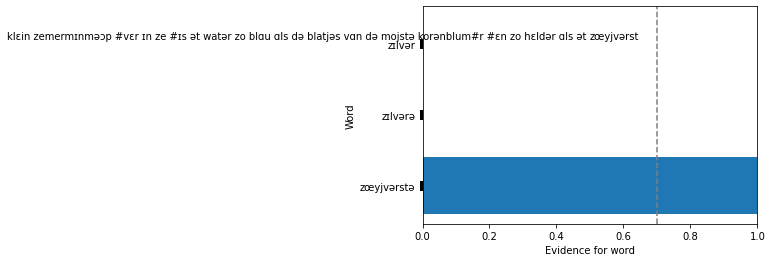

In [15]:
fig, ax = plt.subplots()
k = 3
threshold = 0.7

ax.set_xlim((0, 1))
ax.set_xlabel("Evidence for word")
ax.set_ylabel("Word")

bar = ax.barh([str(i) * 15 for i in range(k)], [0] * k)
threshold_line = ax.axvline(threshold, color="gray", linestyle="--")
prev_label = ax.annotate("", (0.49, 0.85), xycoords="axes fraction", ha="right")
incremental_label = ax.annotate("abc", (0.5, 0.85), xycoords="axes fraction")
prev_incremental_text = [None]
acc_text = []

def animate(i):
    token_idx, incremental_idx = plot_idxs_flat[i]
    incremental_text, incremental_dist = plot_data[token_idx][incremental_idx]
    
    xticklabels = ax.get_xticklabels()
    artists = list(bar) + xticklabels
    
    for i, ((p_i, option_i), bar_i, label_i) in enumerate(zip(incremental_dist, bar, xticklabels)):
        bar_i.set_width(p_i)
        
        # Doesn't work .. do it differently below
        # label_i.set_text(option_i)
        
    ax.set_yticklabels([option_i for _, option_i in incremental_dist])
    ax.tick_params("y", width=10)
    
    if prev_incremental_text[0] is not None and not incremental_text.startswith(prev_incremental_text[0]):
        acc_text.append(prev_incremental_text[0])
        prev_label.set_text(" ".join(acc_text))
        artists.append(prev_label)
        
    incremental_label.set_text(incremental_text)
    artists.append(incremental_label)
    prev_incremental_text[0] = incremental_text
        
    return artists

plt.ioff()
# frames = len(plot_idxs_flat)
frames = 100
anim = FuncAnimation(fig, animate, frames=frames, blit=True, repeat=True, interval=750)
HTML(anim.to_html5_video())

In [ ]:
from collections import deque

from matplotlib.widgets import Button, Slider
import numpy as np

class TimeSeriesPlot:

    def __init__(self, data, display_len):
        self.buff = deque(np.zeros(display_len))
        self.display_len = display_len
        self.data = data

        # set up the plot
        self.fig = plt.figure()
        self.ax = self.fig.add_subplot(111, xlim=(0, t_max), ylim=(-1, 1))
        self.ax.set_xticks((0, t_max))
        self.lines = self.ax.plot([], [])

        # setup the animation
        self.anim = FuncAnimation(self.fig, self._update, repeat=False, blit=True, frames=len(data) - 1,
                                  interval=10.0)

    def _add_to_buff(self, buf, val):
        if len(buf) < self.display_len:
            buf.appendLeft(val)
        else:
            buf.popleft()
            buf.append(val)

    def _update(self, frame):
        self._add_to_buff(self.buff, self.data[frame:frame+1])
        self.lines[0].set_data(range(self.display_len), self.buff)

        self.ax.set_xticklabels((str(frame), str(frame+self.display_len)))

        return self.lines


t_max = 100
lin_sig = np.linspace(0, 1, 1000)
analog_plot = TimeSeriesPlot(lin_sig, t_max)
HTML(analog_plot.anim.to_html5_video())